In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches



In [2]:
from utils import *
import torch.nn as nn

class RegionProposalNetwork(nn.Module):
    r"""
    RPN with following layers on the feature map
        1. 3x3 conv layer followed by Relu
        2. 1x1 classification conv with num_anchors(num_scales x num_aspect_ratios) output channels
        3. 1x1 classification conv with 4 x num_anchors output channels

    Classification is done via one value indicating probability of foreground
    with sigmoid applied during inference
    """
    
    def __init__(self, in_channels, scales, aspect_ratios, model_config):
        super(RegionProposalNetwork, self).__init__()
        self.scales = scales
        self.low_iou_threshold = model_config['rpn_bg_threshold']
        self.high_iou_threshold = model_config['rpn_fg_threshold']
        self.rpn_nms_threshold = model_config['rpn_nms_threshold']
        self.rpn_batch_size = model_config['rpn_batch_size']
        self.rpn_pos_count = int(model_config['rpn_pos_fraction'] * self.rpn_batch_size)
        self.rpn_topk = model_config['rpn_train_topk'] if self.training else model_config['rpn_test_topk']
        self.rpn_prenms_topk = model_config['rpn_train_prenms_topk'] if self.training \
            else model_config['rpn_test_prenms_topk']
        self.aspect_ratios = aspect_ratios
        self.num_anchors = len(self.scales) * len(self.aspect_ratios)
        
        # 3x3 conv layer
        self.rpn_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        
        # 1x1 classification conv layer
        self.cls_layer = nn.Conv2d(in_channels, self.num_anchors, kernel_size=1, stride=1)
        
        # 1x1 regression
        self.bbox_reg_layer = nn.Conv2d(in_channels, self.num_anchors * 4, kernel_size=1, stride=1)
        
        for layer in [self.rpn_conv, self.cls_layer, self.bbox_reg_layer]:
            torch.nn.init.normal_(layer.weight, std=0.01)
            torch.nn.init.constant_(layer.bias, 0)
    
    def generate_anchors(self, image, feat):
        r"""
        Method to generate anchors. First we generate one set of zero-centred anchors
        using the scales and aspect ratios provided.
        We then generate shift values in x,y axis for all featuremap locations.
        The single zero centred anchors generated are replicated and shifted accordingly
        to generate anchors for all feature map locations.
        Note that these anchors are generated such that their centre is top left corner of the
        feature map cell rather than the centre of the feature map cell.
        :param image: (N, C, H, W) tensor
        :param feat: (N, C_feat, H_feat, W_feat) tensor
        :return: anchor boxes of shape (H_feat * W_feat * num_anchors_per_location, 4)
        """
        grid_h, grid_w = feat.shape[-2:]
        image_h, image_w = image.shape[-2:]
        
        # For the vgg16 case stride would be 16 for both h and w
        stride_h = torch.tensor(image_h // grid_h, dtype=torch.int64, device=feat.device)
        stride_w = torch.tensor(image_w // grid_w, dtype=torch.int64, device=feat.device)
        
        scales = torch.as_tensor(self.scales, dtype=feat.dtype, device=feat.device)
        aspect_ratios = torch.as_tensor(self.aspect_ratios, dtype=feat.dtype, device=feat.device)
        
        # Assuming anchors of scale 128 sq pixels
        # For 1:1 it would be (128, 128) -> area=16384
        # For 2:1 it would be (181.02, 90.51) -> area=16384
        # For 1:2 it would be (90.51, 181.02) -> area=16384
        
        # The below code ensures h/w = aspect_ratios and h*w=1
        h_ratios = torch.sqrt(aspect_ratios)
        w_ratios = 1 / h_ratios
        
        # Now we will just multiply h and w with scale(example 128)
        # to make h*w = 128 sq pixels and h/w = aspect_ratios
        # This gives us the widths and heights of all anchors
        # which we need to replicate at all locations
        ws = (w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h_ratios[:, None] * scales[None, :]).view(-1)
        
        # Now we make all anchors zero centred
        # So x1, y1, x2, y2 = -w/2, -h/2, w/2, h/2
        base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
        base_anchors = base_anchors.round()
        
        # Get the shifts in x axis (0, 1,..., W_feat-1) * stride_w
        shifts_x = torch.arange(0, grid_w, dtype=torch.int32, device=feat.device) * stride_w

        # Get the shifts in x axis (0, 1,..., H_feat-1) * stride_h
        shifts_y = torch.arange(0, grid_h, dtype=torch.int32, device=feat.device) * stride_h
        
        # Create a grid using these shifts
        shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
        # shifts_x -> (H_feat, W_feat)
        # shifts_y -> (H_feat, W_feat)
        
        shifts_x = shifts_x.reshape(-1)
        shifts_y = shifts_y.reshape(-1)
        # Setting shifts for x1 and x2(same as shifts_x) and y1 and y2(same as shifts_y)
        shifts = torch.stack((shifts_x, shifts_y, shifts_x, shifts_y), dim=1)
        # shifts -> (H_feat * W_feat, 4)
        
        # base_anchors -> (num_anchors_per_location, 4)
        # shifts -> (H_feat * W_feat, 4)
        # Add these shifts to each of the base anchors
        anchors = (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4))
        # anchors -> (H_feat * W_feat, num_anchors_per_location, 4)
        anchors = anchors.reshape(-1, 4)
        # anchors -> (H_feat * W_feat * num_anchors_per_location, 4)
        return anchors
    
    def assign_targets_to_anchors(self, anchors, gt_boxes):
        r"""
        For each anchor assign a ground truth box based on the IOU.
        Also creates classification labels to be used for training
        label=1 for anchors where maximum IOU with a gtbox > high_iou_threshold
        label=0 for anchors where maximum IOU with a gtbox < low_iou_threshold
        label=-1 for anchors where maximum IOU with a gtbox between (low_iou_threshold, high_iou_threshold)
        :param anchors: (num_anchors_in_image, 4) all anchor boxes
        :param gt_boxes: (num_gt_boxes_in_image, 4) all ground truth boxes
        :return:
            label: (num_anchors_in_image) {-1/0/1}
            matched_gt_boxes: (num_anchors_in_image, 4) coordinates of assigned gt_box to each anchor
                Even background/to_be_ignored anchors will be assigned some ground truth box.
                It's fine, we will use label to differentiate those instances later
        """
        
        # Get (gt_boxes, num_anchors_in_image) IOU matrix
        iou_matrix = get_iou(gt_boxes, anchors)
        
        # For each anchor get the gt box index with maximum overlap
        best_match_iou, best_match_gt_idx = iou_matrix.max(dim=0)
        # best_match_gt_idx -> (num_anchors_in_image)
        
        # This copy of best_match_gt_idx will be needed later to
        # add low quality matches
        best_match_gt_idx_pre_thresholding = best_match_gt_idx.clone()
        
        # Based on threshold, update the values of best_match_gt_idx
        # For anchors with highest IOU < low_threshold update to be -1
        # For anchors with highest IOU between low_threshold & high threshold update to be -2
        below_low_threshold = best_match_iou < self.low_iou_threshold
        between_thresholds = (best_match_iou >= self.low_iou_threshold) & (best_match_iou < self.high_iou_threshold)
        best_match_gt_idx[below_low_threshold] = -1
        best_match_gt_idx[between_thresholds] = -2
        
        # Add low quality anchor boxes, if for a given ground truth box, these are the ones
        # that have highest IOU with that gt box
        
        # For each gt box, get the maximum IOU value amongst all anchors
        best_anchor_iou_for_gt, _ = iou_matrix.max(dim=1)
        # best_anchor_iou_for_gt -> (num_gt_boxes_in_image)
        
        # For each gt box get those anchors
        # which have this same IOU as present in best_anchor_iou_for_gt
        # This is to ensure if 10 anchors all have the same IOU value,
        # which is equal to the highest IOU that this gt box has with any anchor
        # then we get all these 10 anchors
        gt_pred_pair_with_highest_iou = torch.where(iou_matrix == best_anchor_iou_for_gt[:, None])
        # gt_pred_pair_with_highest_iou -> [0, 0, 0, 1, 1, 1], [8896,  8905,  8914, 10472, 10805, 11138]
        # This means that anchors at the first 3 indexes have an IOU with gt box at index 0
        # which is equal to the highest IOU that this gt box has with ANY anchor
        # Similarly anchor at last three indexes(10472, 10805, 11138) have an IOU with gt box at index 1
        # which is equal to the highest IOU that this gt box has with ANY anchor
        # These 6 anchor indexes will also be added as positive anchors
        
        # Get all the anchors indexes to update
        pred_inds_to_update = gt_pred_pair_with_highest_iou[1]
        
        # Update the matched gt index for all these anchors with whatever was the best gt box
        # prior to thresholding
        best_match_gt_idx[pred_inds_to_update] = best_match_gt_idx_pre_thresholding[pred_inds_to_update]
        
        # best_match_gt_idx is either a valid index for all anchors or -1(background) or -2(to be ignored)
        # Clamp this so that the best_match_gt_idx is a valid non-negative index
        # At this moment the -1 and -2 labelled anchors will be mapped to the 0th gt box
        matched_gt_boxes = gt_boxes[best_match_gt_idx.clamp(min=0)]
        
        # Set all foreground anchor labels as 1
        labels = best_match_gt_idx >= 0
        labels = labels.to(dtype=torch.float32)
        
        # Set all background anchor labels as 0
        background_anchors = best_match_gt_idx == -1
        labels[background_anchors] = 0.0
        
        # Set all to be ignored anchor labels as -1
        ignored_anchors = best_match_gt_idx == -2
        labels[ignored_anchors] = -1.0
        # Later for classification we will only pick labels which have > 0 label
        
        return labels, matched_gt_boxes

    def filter_proposals(self, proposals, cls_scores, image_shape):
        r"""
        This method does three kinds of filtering/modifications
        1. Pre NMS topK filtering
        2. Make proposals valid by clamping coordinates(0, width/height)
        2. Small Boxes filtering based on width and height
        3. NMS
        4. Post NMS topK filtering
        :param proposals: (num_anchors_in_image, 4)
        :param cls_scores: (num_anchors_in_image, 4) these are cls logits
        :param image_shape: resized image shape needed to clip proposals to image boundary
        :return: proposals and cls_scores: (num_filtered_proposals, 4) and (num_filtered_proposals)
        """
        # Pre NMS Filtering
        cls_scores = cls_scores.reshape(-1)
        cls_scores = torch.sigmoid(cls_scores)
        _, top_n_idx = cls_scores.topk(min(self.rpn_prenms_topk, len(cls_scores)))
        
        cls_scores = cls_scores[top_n_idx]
        proposals = proposals[top_n_idx]
        ##################
        
        # Clamp boxes to image boundary
        proposals = clamp_boxes_to_image_boundary(proposals, image_shape)
        ####################
        
        # Small boxes based on width and height filtering
        min_size = 16
        ws, hs = proposals[:, 2] - proposals[:, 0], proposals[:, 3] - proposals[:, 1]
        keep = (ws >= min_size) & (hs >= min_size)
        keep = torch.where(keep)[0]
        proposals = proposals[keep]
        cls_scores = cls_scores[keep]
        ####################
        
        # NMS based on objectness scores
        keep_mask = torch.zeros_like(cls_scores, dtype=torch.bool)
        keep_indices = torch.ops.torchvision.nms(proposals, cls_scores, self.rpn_nms_threshold)
        keep_mask[keep_indices] = True
        keep_indices = torch.where(keep_mask)[0]
        # Sort by objectness
        post_nms_keep_indices = keep_indices[cls_scores[keep_indices].sort(descending=True)[1]]
        
        # Post NMS topk filtering
        proposals, cls_scores = (proposals[post_nms_keep_indices[:self.rpn_topk]],
                                 cls_scores[post_nms_keep_indices[:self.rpn_topk]])
        
        return proposals, cls_scores
    
    def forward(self, image, feat, target=None):
        r"""
        Main method for RPN does the following:
        1. Call RPN specific conv layers to generate classification and
            bbox transformation predictions for anchors
        2. Generate anchors for entire image
        3. Transform generated anchors based on predicted bbox transformation to generate proposals
        4. Filter proposals
        5. For training additionally we do the following:
            a. Assign target ground truth labels and boxes to each anchors
            b. Sample positive and negative anchors
            c. Compute classification loss using sampled pos/neg anchors
            d. Compute Localization loss using sampled pos anchors
        :param image:
        :param feat:
        :param target:
        :return:
        """
        # Call RPN layers
        rpn_feat = nn.ReLU()(self.rpn_conv(feat))
        cls_scores = self.cls_layer(rpn_feat)
        box_transform_pred = self.bbox_reg_layer(rpn_feat)

        # Generate anchors
        anchors = self.generate_anchors(image, feat)
        
        # Reshape classification scores to be (Batch Size * H_feat * W_feat * Number of Anchors Per Location, 1)
        # cls_score -> (Batch_Size, Number of Anchors per location, H_feat, W_feat)
        number_of_anchors_per_location = cls_scores.size(1)
        cls_scores = cls_scores.permute(0, 2, 3, 1)
        cls_scores = cls_scores.reshape(-1, 1)
        # cls_score -> (Batch_Size*H_feat*W_feat*Number of Anchors per location, 1)
        
        # Reshape bbox predictions to be (Batch Size * H_feat * W_feat * Number of Anchors Per Location, 4)
        # box_transform_pred -> (Batch_Size, Number of Anchors per location*4, H_feat, W_feat)
        box_transform_pred = box_transform_pred.view(
            box_transform_pred.size(0),
            number_of_anchors_per_location,
            4,
            rpn_feat.shape[-2],
            rpn_feat.shape[-1])
        box_transform_pred = box_transform_pred.permute(0, 3, 4, 1, 2)
        box_transform_pred = box_transform_pred.reshape(-1, 4)
        # box_transform_pred -> (Batch_Size*H_feat*W_feat*Number of Anchors per location, 4)
        
        # Transform generated anchors according to box transformation prediction
        proposals = apply_regression_pred_to_anchors_or_proposals(
            box_transform_pred.detach().reshape(-1, 1, 4),
            anchors)
        proposals = proposals.reshape(proposals.size(0), 4)
        ######################
        
        proposals, scores = self.filter_proposals(proposals, cls_scores.detach(), image.shape)
        rpn_output = {
            'proposals': proposals,
            'scores': scores
        }
        if not self.training or target is None:
            # If we are not training no need to do anything
            return rpn_output
        else:
            # Assign gt box and label for each anchor
            labels_for_anchors, matched_gt_boxes_for_anchors = self.assign_targets_to_anchors(
                anchors,
                target['bboxes'][0])
            
            # Based on gt assignment above, get regression target for the anchors
            # matched_gt_boxes_for_anchors -> (Number of anchors in image, 4)
            # anchors -> (Number of anchors in image, 4)
            regression_targets = boxes_to_transformation_targets(matched_gt_boxes_for_anchors, anchors)
            
            ####### Sampling positive and negative anchors ####
            # Our labels were {fg:1, bg:0, to_be_ignored:-1}
            sampled_neg_idx_mask, sampled_pos_idx_mask = sample_positive_negative(
                labels_for_anchors,
                positive_count=self.rpn_pos_count,
                total_count=self.rpn_batch_size)
            
            sampled_idxs = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]
            
            localization_loss = (
                    torch.nn.functional.smooth_l1_loss(
                        box_transform_pred[sampled_pos_idx_mask],
                        regression_targets[sampled_pos_idx_mask],
                        beta=1 / 9,
                        reduction="sum",
                    )
                    / (sampled_idxs.numel())
            ) 

            cls_loss = torch.nn.functional.binary_cross_entropy_with_logits(cls_scores[sampled_idxs].flatten(),
                                                                            labels_for_anchors[sampled_idxs].flatten())

            rpn_output['rpn_classification_loss'] = cls_loss
            rpn_output['rpn_localization_loss'] = localization_loss
            return rpn_output

ModuleNotFoundError: No module named 'utils'

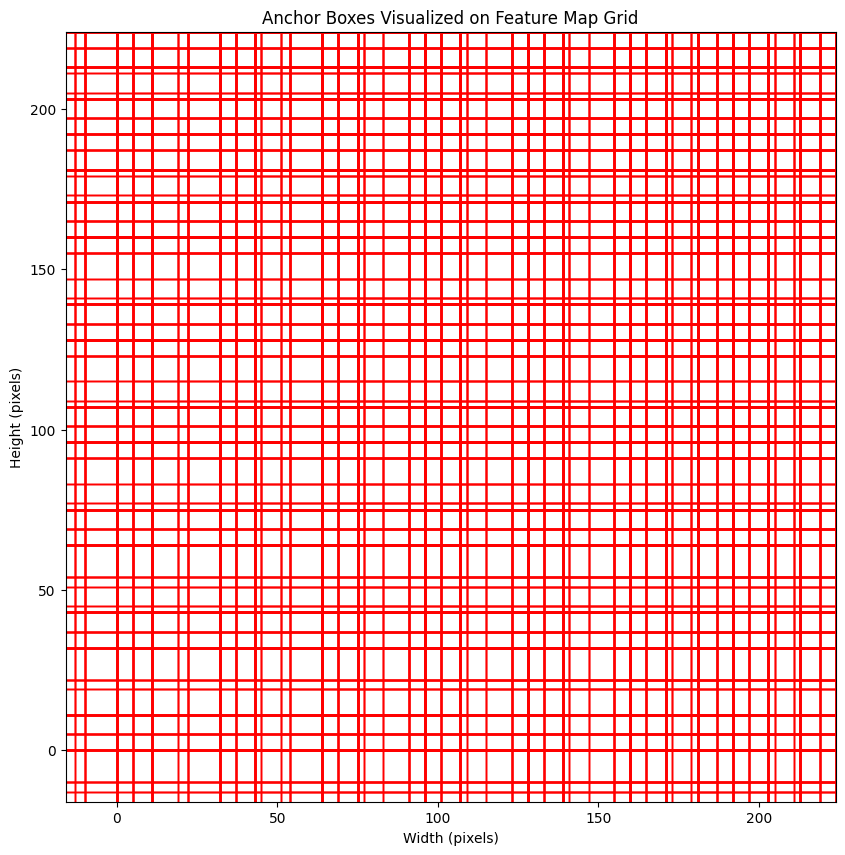

In [5]:
image = torch.zeros((1, 3, 224, 224))  # (N, C, H, W) format
# Simulate a feature map produced by a backbone network, e.g., VGG16
# If the image is 224x224, a typical VGG16 feature map (after a few layers) might be around 14x14 or 7x7
feat = torch.zeros((1, 512, 14, 14))  # (N, C_feat, H_feat, W_feat)

# Example scales and aspect ratios (these would normally be attributes in your model)
self = type('', (), {})()  # Create a dummy self object for example
self.scales = [128, 256, 512]  # Example anchor scales in pixels
self.aspect_ratios = [0.5, 1.0, 2.0]  # Example aspect ratios

# Define the generate_anchors function with this context
def generate_anchors(image, feat):
    """
    Generates anchor boxes based on image and feature map dimensions.
    """
    grid_h, grid_w = feat.shape[-2:]
    image_h, image_w = image.shape[-2:]
    
    stride_h = torch.tensor(image_h // grid_h, dtype=torch.int64, device=feat.device)
    stride_w = torch.tensor(image_w // grid_w, dtype=torch.int64, device=feat.device)
    
    scales = torch.as_tensor(self.scales, dtype=feat.dtype, device=feat.device)
    aspect_ratios = torch.as_tensor(self.aspect_ratios, dtype=feat.dtype, device=feat.device)
    
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1 / h_ratios
    
    ws = (w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h_ratios[:, None] * scales[None, :]).view(-1)
    
    base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
    base_anchors = base_anchors.round()
    
    shifts_x = torch.arange(0, grid_w, dtype=torch.int32, device=feat.device) * stride_w
    shifts_y = torch.arange(0, grid_h, dtype=torch.int32, device=feat.device) * stride_h
    
    shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
    shifts_x = shifts_x.reshape(-1)
    shifts_y = shifts_y.reshape(-1)
    
    shifts = torch.stack((shifts_x, shifts_y, shifts_x, shifts_y), dim=1)
    anchors = (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4)
    
    return anchors

# Generate the anchors using the sample image and feat tensors
sample_anchors = generate_anchors(image, feat)

# Now we can visualize the anchors using the previous function
sample_grid_h, sample_grid_w = feat.shape[-2:]  # 14x14 for our example
sample_stride_h, sample_stride_w = image.shape[-2] // sample_grid_h, image.shape[-1] // sample_grid_w
num_anchors_per_location = len(self.scales) * len(self.aspect_ratios)

# Visualize anchors
visualize_anchors(sample_anchors, sample_grid_h, sample_grid_w, sample_stride_h, sample_stride_w, num_anchors_per_location)